# Part 2

In [290]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.ensemble import VotingClassifier

import warnings
warnings.filterwarnings('ignore')

## EDA

In [113]:
mush = pd.read_csv('mushrooms.csv')
print(mush.shape)
mush.head()

(8124, 23)


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [114]:
mush.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

모든 칼럼에 대해 값이 모두 문자열이다.

In [115]:
# 각 칼럼들에 대한 unique값 확인
for column in mush.columns:
    print('unique values in', column, ':', mush[column].unique())

unique values in class : ['p' 'e']
unique values in cap-shape : ['x' 'b' 's' 'f' 'k' 'c']
unique values in cap-surface : ['s' 'y' 'f' 'g']
unique values in cap-color : ['n' 'y' 'w' 'g' 'e' 'p' 'b' 'u' 'c' 'r']
unique values in bruises : ['t' 'f']
unique values in odor : ['p' 'a' 'l' 'n' 'f' 'c' 'y' 's' 'm']
unique values in gill-attachment : ['f' 'a']
unique values in gill-spacing : ['c' 'w']
unique values in gill-size : ['n' 'b']
unique values in gill-color : ['k' 'n' 'g' 'p' 'w' 'h' 'u' 'e' 'b' 'r' 'y' 'o']
unique values in stalk-shape : ['e' 't']
unique values in stalk-root : ['e' 'c' 'b' 'r' '?']
unique values in stalk-surface-above-ring : ['s' 'f' 'k' 'y']
unique values in stalk-surface-below-ring : ['s' 'f' 'y' 'k']
unique values in stalk-color-above-ring : ['w' 'g' 'p' 'n' 'b' 'e' 'o' 'c' 'y']
unique values in stalk-color-below-ring : ['w' 'p' 'g' 'b' 'n' 'e' 'y' 'o' 'c']
unique values in veil-type : ['p']
unique values in veil-color : ['w' 'n' 'o' 'y']
unique values in ring-num

stalk-root에 '?'라는 값이 있다. 이를 살펴보도록 한다.

In [116]:
unknown = mush[mush['stalk-root']=='?']
unknown.shape

(2480, 23)

총 2480개의 observation에 대해 stalk-root의 값의 '?'이다. 이는 전체 데이터의 약 30%로, 이를 모두 제거하면 데이터의 손실이 커지기 때문에 정확한 분류를 하지 못할 수 있다. 따라서, 이에 대해 interpolation 보간법을 활용하여 채워줄 것이다.

In [118]:
# 'stalk-root' 칼럼 값 분포 확인
mush['stalk-root'].value_counts()/len(mush)

b    0.464796
?    0.305268
e    0.137863
c    0.068439
r    0.023634
Name: stalk-root, dtype: float64

?를 대체하여 채워줄 값은 해당 칼럼의 최빈값으로 할 것이다. 위의 'stalk-root'칼럼 값들의 분포를 보면, 약 46%가 b이고, ?를 제외한 나머지 값들은 합쳐서 약 22% 정도이다. 대부분의 값이 b라는 것을 알 수 있으며, 결측치인 ?에 대해서도 상당수가 b일 가능성이 크다는 것을 나타낸다. 따라서, 여러 방법 중 최빈값인 b를 사용하여 채워주는 것이 가장 합리적이라고 판단했다.

In [119]:
# '?'를 결측치 처리
mush = mush.replace('?', np.nan)
# 해당 칼럼의 최빈값으로 보간
mush['stalk-root'].fillna(mush['stalk-root'].mode()[0], inplace=True)

In [120]:
# 결측치 '?' 대체 결과 확인
mush['stalk-root'].value_counts()/len(mush)

b    0.770064
e    0.137863
c    0.068439
r    0.023634
Name: stalk-root, dtype: float64

In [106]:
# 결측치 확인
mush.isnull().sum()

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

결측치는 없다. 변수들이 모두 categorical 변수이므로 countplot을 그려 각 칼럼별 값의 분포를 알아보았다.

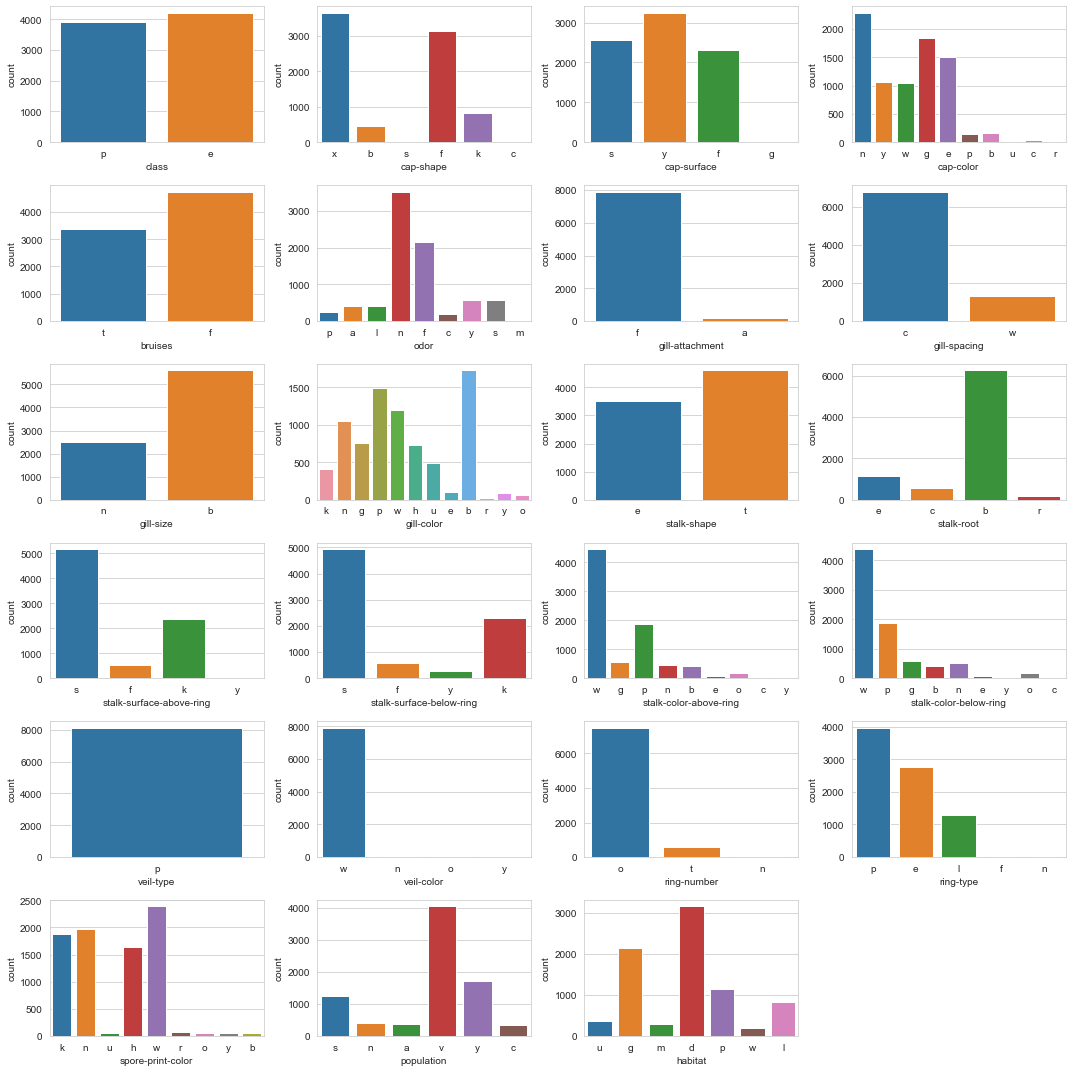

In [133]:
# 칼럼별 countplot
plt.figure(figsize=(15,15))
for i, cat in enumerate(mush.columns):
    ax = plt.subplot(6,4,i+1)
    sns.set_style('whitegrid')
    sns.countplot(data = mush, x = cat, ax = ax)
    plt.tight_layout()
plt.show()

변수의 분포를 본 결과, target 값인 class는 한 쪽에 치우지지 않고 개수가 비슷하다.

또한, 'veil-type' 변수의 경우 값이 1개이므로, 해당 변수가 y에 미치는 영향이 없을 것이라고 판단하여 제거하였다.

In [134]:
mush = mush.drop(columns='veil-type', axis=1)

나머지 변수들에 대해서는 각 변수별로 order가 없기 때문에 더미화를 진행하였다. 따라서 모든 변수가 0과 1로만 구성된 것으로 바뀌었다.

In [135]:
# 변수 전체 더미화
mush_new = pd.get_dummies(data = mush)
# target 변수(p인 경우 1, e인 경우 0)
mush_new = mush_new.iloc[:,1:]

# 최종 데이터셋 형태
mush_new.head(5)

,class_p,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,1,0,0,0,0,0,1,0,0,1,...,1,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,1,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0


class_p가 target변수이며, p인 경우 1, e인 경우 0으로 분류되어있다.

또한, 칼럼이 모두 binary 형태이므로 스케일링을 따로 진행하지 않았다.

## train/test set 분리

In [108]:
y = mush_new['class_p']
X = mush_new.drop('class_p',axis=1, inplace=False)

# training set 80%, test set 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021)

## 모델링

#### 기본 모델 지정

In [160]:
rf_clf = RandomForestClassifier(n_estimators = 100, random_state = 2021)
et_clf = ExtraTreesClassifier(n_estimators=100, random_state=2021)
df_clf = DecisionTreeClassifier(random_state = 2021)
svm_clf = SVC(gamma='scale', random_state = 2021)
log_clf = LogisticRegression(solver = "lbfgs", random_state = 2021)
gb_clf = GradientBoostingClassifier(n_estimators = 100, random_state = 2021)
ada_clf = AdaBoostClassifier(n_estimators=100, random_state=2021)

In [196]:
for model in (rf_clf, et_clf, df_clf, svm_clf, log_clf, gb_clf, ada_clf):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(model.__class__.__name__, f1_score(y_test, y_pred))

RandomForestClassifier 1.0
ExtraTreesClassifier 1.0
DecisionTreeClassifier 1.0
SVC 1.0
LogisticRegression 1.0
GradientBoostingClassifier 1.0
AdaBoostClassifier 1.0


train, test를 미리 하고 기본 모델로 f1_score를 계산한 결과 모두 1로, 모든 모델이 완벽하게 분류해내는 것을 확인했다. 하지만, 이는 train, test set을 분리하는 과정에서 특정 random_state에서 split을 했을 때 나오는 결과일 수 있으므로 교차검증을 통해 다시 계산해보았다.

y(target)의 분포를 살펴보면, 0과 1이 거의 비슷한 개수로 분포하므로 StratifiedKFold를 사용하지 않고, KFold를 사용해도 무방하다. cross_val_score 함수는 기본적으로 KFold로 교차검증을 진행한다.

In [203]:
# kfold 교차검증시 train, test split 전 데이터 shuffle이 안 된 경우
for model in (rf_clf, et_clf, df_clf, svm_clf, log_clf, gb_clf, ada_clf):
    # 5겹 교차검증으로, train과 test set을 각각 80%, 20%로 나눈다.
    cv_score = cross_val_score(model, X, y, cv=5, scoring='f1')  
    print(model.__class__.__name__, 'f1 score: ', np.round(cv_score.mean(),4), 
          '/each score of 5 fold: ', np.round(cv_score,4))

RandomForestClassifier f1 score:  0.9128 /each score of 5 fold:  [0.8049 1.     1.     1.     0.7591]
ExtraTreesClassifier f1 score:  0.9176 /each score of 5 fold:  [0.8049 1.     1.     1.     0.783 ]
DecisionTreeClassifier f1 score:  0.9571 /each score of 5 fold:  [0.8049 1.     0.9955 1.     0.9849]
SVC f1 score:  0.8925 /each score of 5 fold:  [0.8049 1.     0.9955 1.     0.6622]
LogisticRegression f1 score:  0.9234 /each score of 5 fold:  [0.9561 1.     0.9825 1.     0.6786]
GradientBoostingClassifier f1 score:  0.9598 /each score of 5 fold:  [1.    1.    1.    1.    0.799]
AdaBoostClassifier f1 score:  0.9208 /each score of 5 fold:  [0.8049 1.     1.     1.     0.799 ]


5개의 fold 중 어떤 fold를 test set으로 사용하는지에 따라 정확도가 매우 상이하다. 이는 데이터 순서대로 5개로 나누었기 때문에 fold에 따라 데이터가 고르게 분포되어 있지 않고 어떠한 특성이 편중되어있을 수 있기 때문이다. DecisionTreeclassifier를 제외한 모든 모델에서 5번째 계산된 f1 score가 가장 낮은 것도 이를 보여준다. 따라서, fold로 나누기 전에 데이터를 랜덤하게 shuffle을 하는 방법으로 다시 교차검증을 해보았고, shuffle을 했을 때가 하지 않았을 때보다 5번 모두 비슷한 결과를 도출해내는 것을 확인하였다.

random_state에 따라 결과가 달라지므로 이를 바꿔가면서 결과를 도출하였다.

In [204]:
# kfold 교차검증시 train, test split 전 데이터 shuffle이 된 경우
for model in (rf_clf, et_clf, df_clf, svm_clf, log_clf, gb_clf, ada_clf):
    # 5겹 교차검증으로, train과 test set을 각각 80%, 20%로 나눈다.
    cv = KFold(n_splits=5, shuffle=True, random_state=201)
    cv_score = cross_val_score(model, X, y, cv=cv, scoring='f1')  
    print(model.__class__.__name__, 'f1 score: ', np.round(cv_score.mean(),4), 
          '/each score of 5 fold: ', np.round(cv_score,4))

RandomForestClassifier f1 score:  1.0 /each score of 5 fold:  [1. 1. 1. 1. 1.]
ExtraTreesClassifier f1 score:  1.0 /each score of 5 fold:  [1. 1. 1. 1. 1.]
DecisionTreeClassifier f1 score:  0.9998 /each score of 5 fold:  [0.9988 1.     1.     1.     1.    ]
SVC f1 score:  1.0 /each score of 5 fold:  [1. 1. 1. 1. 1.]
LogisticRegression f1 score:  0.9998 /each score of 5 fold:  [0.9988 1.     1.     1.     1.    ]
GradientBoostingClassifier f1 score:  0.9998 /each score of 5 fold:  [0.9988 1.     1.     1.     1.    ]
AdaBoostClassifier f1 score:  1.0 /each score of 5 fold:  [1. 1. 1. 1. 1.]


In [205]:
# kfold 교차검증시 train, test split 전 데이터 shuffle이 된 경우
for model in (rf_clf, et_clf, df_clf, svm_clf, log_clf, gb_clf, ada_clf):
    # 5겹 교차검증으로, train과 test set을 각각 80%, 20%로 나눈다.
    cv = KFold(n_splits=5, shuffle=True, random_state=111)
    cv_score = cross_val_score(model, X, y, cv=cv, scoring='f1')  
    print(model.__class__.__name__, 'f1 score: ', np.round(cv_score.mean(),4), 
          '/each score of 5 fold: ', np.round(cv_score,4))

RandomForestClassifier f1 score:  1.0 /each score of 5 fold:  [1. 1. 1. 1. 1.]
ExtraTreesClassifier f1 score:  1.0 /each score of 5 fold:  [1. 1. 1. 1. 1.]
DecisionTreeClassifier f1 score:  1.0 /each score of 5 fold:  [1. 1. 1. 1. 1.]
SVC f1 score:  1.0 /each score of 5 fold:  [1. 1. 1. 1. 1.]
LogisticRegression f1 score:  0.9995 /each score of 5 fold:  [1.     0.9994 1.     1.     0.9981]
GradientBoostingClassifier f1 score:  1.0 /each score of 5 fold:  [1. 1. 1. 1. 1.]
AdaBoostClassifier f1 score:  1.0 /each score of 5 fold:  [1. 1. 1. 1. 1.]


In [206]:
# kfold 교차검증시 train, test split 전 데이터 shuffle이 된 경우
for model in (rf_clf, et_clf, df_clf, svm_clf, log_clf, gb_clf, ada_clf):
    # 5겹 교차검증으로, train과 test set을 각각 80%, 20%로 나눈다.
    cv = KFold(n_splits=5, shuffle=True, random_state=10000)
    cv_score = cross_val_score(model, X, y, cv=cv, scoring='f1')  
    print(model.__class__.__name__, 'f1 score: ', np.round(cv_score.mean(),4), 
          '/each score of 5 fold: ', np.round(cv_score,4))

RandomForestClassifier f1 score:  1.0 /each score of 5 fold:  [1. 1. 1. 1. 1.]
ExtraTreesClassifier f1 score:  1.0 /each score of 5 fold:  [1. 1. 1. 1. 1.]
DecisionTreeClassifier f1 score:  1.0 /each score of 5 fold:  [1. 1. 1. 1. 1.]
SVC f1 score:  1.0 /each score of 5 fold:  [1. 1. 1. 1. 1.]
LogisticRegression f1 score:  0.9997 /each score of 5 fold:  [1.     1.     1.     0.9987 1.    ]
GradientBoostingClassifier f1 score:  1.0 /each score of 5 fold:  [1. 1. 1. 1. 1.]
AdaBoostClassifier f1 score:  1.0 /each score of 5 fold:  [1. 1. 1. 1. 1.]


데이터를 섞고 나서 교차검증을 수행한 결과, 거의 모든 모델의 5번의 시행에서 f1 score가 1이 나왔다. 1이 아닌 경우에도 0.999로 1에 매우 가까운 score를 가졌다. 기본 모델들의 경우에는 모두 거의 완벽한 분류를 해냈기 때문에 성능을 비교하기 쉽지 않았다. 모델 별로 과적합 가능성도 배제할 수 없어 각 모델 별로 그리드서치를 통한 하이퍼파라미터 튜닝을 해보고자 한다.

------------------------------------

### RandomForestClassifier

위에서 기본 모델로 사용했던 rf_clf 모델은 과적합되기 쉬운 모델이다. 특히 깊이가 깊어질수록 과적합 가능성이 높아진다. 따라서 max_depth 파라미터를 조정하여 결과를 다시 계산해보았다.

In [207]:
rf_clf_1 = RandomForestClassifier(n_estimators = 100, max_depth = 5, random_state = 2021)

In [209]:
cv = KFold(n_splits=5, shuffle=True, random_state=10000)
cv_score = cross_val_score(rf_clf_1, X, y, cv=cv, scoring='f1')  
print('RandomForestClassifier f1 score: ', np.round(cv_score.mean(),4), 
          '/each score of 5 fold: ', np.round(cv_score,4))

RandomForestClassifier f1 score:  0.9897 /each score of 5 fold:  [0.9857 0.9916 0.9887 0.9884 0.9941]


그 결과 f1 score가 0.9897로 감소하였다. 

그리드 서치를 사용하여 추가적인 튜닝을 시도해보았다.

In [213]:
rf_clf_0 =  RandomForestClassifier(random_state = 2021)

param_grid = [
    {'max_depth':[3, 4, 5], 
    'min_samples_split':[3, 4, 5],
    'max_leaf_nodes':[8, 9, 10],
    'n_estimators': [10, 100, 200]}
]

result = GridSearchCV(rf_clf_0, param_grid = param_grid, scoring = 'f1', cv = 5)
result.fit(X, y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=2021),
             param_grid=[{'max_depth': [3, 4, 5], 'max_leaf_nodes': [8, 9, 10],
                          'min_samples_split': [3, 4, 5],
                          'n_estimators': [10, 100, 200]}],
             scoring='f1')

In [214]:
result.best_params_

{'max_depth': 4,
 'max_leaf_nodes': 10,
 'min_samples_split': 3,
 'n_estimators': 100}

In [245]:
rf_clf_2 =  RandomForestClassifier(max_depth = 4 ,max_leaf_nodes = 10, 
                                   min_samples_split = 3, n_estimators=100, random_state = 2021)

cv = KFold(n_splits=5, shuffle=True, random_state=1)
cv_score = cross_val_score(rf_clf_2, X, y, cv=cv, scoring='f1')  
print('RandomForestClassifier f1 score: ', np.round(cv_score.mean(),4), 
          '/each score of 5 fold: ', np.round(cv_score,4))

RandomForestClassifier f1 score:  0.9893 /each score of 5 fold:  [0.9861 0.9929 0.9911 0.9905 0.9861]


튜닝 결과, 5 fold cv의 mean f1 score는 0.9893이다.

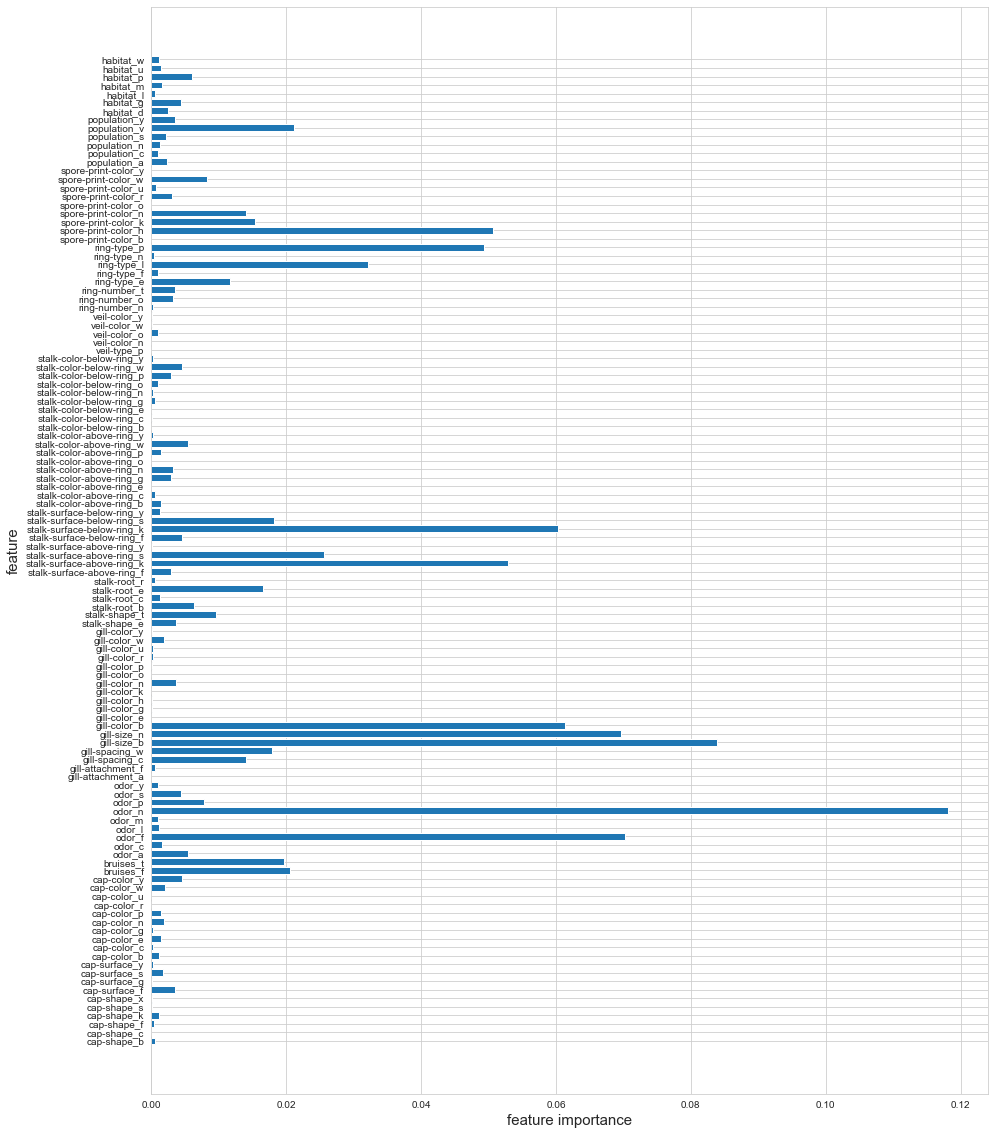

In [299]:
# 변수 중요도
rf_clf_2.fit(X_train, y_train)

feature_imp = rf_clf_2.feature_importances_

n_feature = X.shape[1]
idx = np.arange(n_feature)

plt.figure(figsize=(15,20))
plt.barh(idx, feature_imp, align='center')
plt.yticks(idx, X.columns)
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)
plt.show()

### ExtraTreesClassifier

ExtraTreesClassifier는 랜덤포레스트보다 무작위성을 더 많이 준 모델이다. 하지만 이 모델 또한 트리 기반 알고리즘이기 때문에 파라미터에 따라 과적합 가능성이 존재한다. 이를 방지하기 위해 파라미터 튜닝을 진행하였다.

In [218]:
et_clf_0 = ExtraTreesClassifier(random_state=2021)

param_grid = [
    {'max_depth':[3, 4, 5], 
    'min_samples_split':[3, 4, 5],
    'max_leaf_nodes':[8, 9, 10],
    'n_estimators': [10, 100, 200]}
]

result = GridSearchCV(et_clf_0, param_grid = param_grid, scoring = 'f1', cv = 5)
result.fit(X, y)
result.best_params_

{'max_depth': 3,
 'max_leaf_nodes': 8,
 'min_samples_split': 3,
 'n_estimators': 10}

In [268]:
et_clf_2 =  ExtraTreesClassifier(max_depth = 3 ,max_leaf_nodes = 8, 
                                   min_samples_split = 3, n_estimators=10, random_state = 2021)

cv = KFold(n_splits=5, shuffle=True, random_state=1)
cv_score = cross_val_score(et_clf_2, X, y, cv=cv, scoring='f1')  
print('ExtraTreesClassifier f1 score: ', np.round(cv_score.mean(),4), 
          '/each score of 5 fold: ', np.round(cv_score,4))

ExtraTreesClassifier f1 score:  0.9685 /each score of 5 fold:  [0.9766 0.9729 0.9613 0.9641 0.9675]


튜닝 결과, 5 fold cv의 mean f1 score는 0.9685이다.

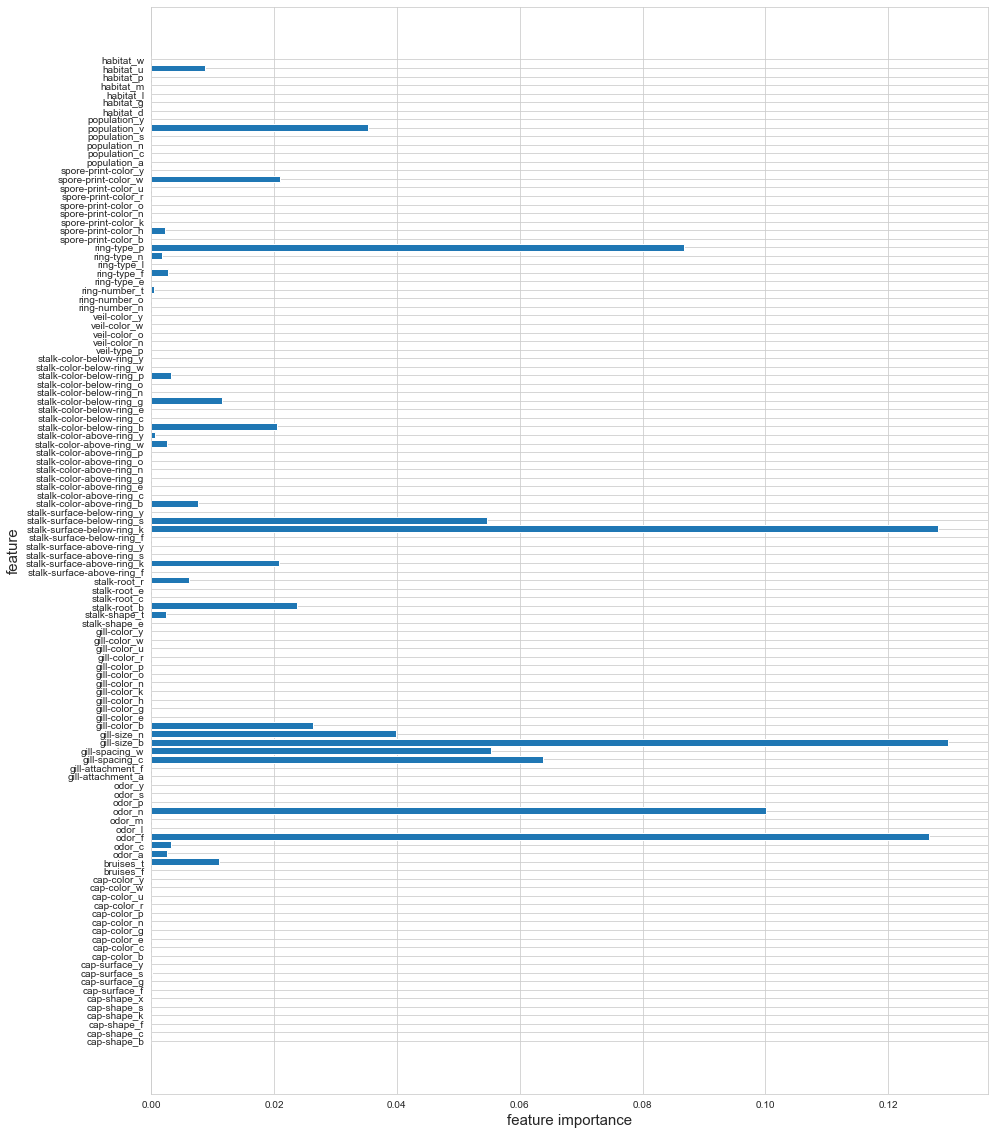

In [297]:
# 변수 중요도
et_clf_2.fit(X_train, y_train)

feature_imp = et_clf_2.feature_importances_

n_feature = X.shape[1]
idx = np.arange(n_feature)

plt.figure(figsize=(15,20))
plt.barh(idx, feature_imp, align='center')
plt.yticks(idx, X.columns)
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)
plt.show()

### SVC

In [294]:
svm_clf_0 = SVC(random_state = 2021)

param_grid = [
    {'C':[0,1, 1, 10], 
    'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    'degree':[3, 4, 5],
    'gamma': ['scale', 'auto']}
]

result = GridSearchCV(svm_clf_0, param_grid = param_grid, scoring = 'f1', cv = 5)
result.fit(X, y)
result.best_params_

{'C': 1, 'degree': 3, 'gamma': 'scale', 'kernel': 'linear'}

In [295]:
svm_clf_2 =  SVC(C=1, degree = 3, gamma = 'scale', 
                 kernel='linear', probability=True, random_state = 2021)

cv = KFold(n_splits=5, shuffle=True, random_state=1)
cv_score = cross_val_score(svm_clf_2, X, y, cv=cv, scoring='f1')  
print('SVC f1 score: ', np.round(cv_score.mean(),4), 
          '/each score of 5 fold: ', np.round(cv_score,4))

SVC f1 score:  1.0 /each score of 5 fold:  [1. 1. 1. 1. 1.]


튜닝 결과, 5 fold cv의 mean f1 score는 1이다.

### LogisticRegression

In [292]:
log_clf_0 = LogisticRegression(random_state = 2021)

param_grid = [
    {'C':[0.1, 1, 10], 
     'penalty':['l1', 'l2', 'elasticnet'],
    'solver':['liblinear', 'Ibfgs']}
]

result = GridSearchCV(log_clf_0, param_grid = param_grid, scoring = 'f1', cv = 5)
result.fit(X, y)
result.best_params_

{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}

In [269]:
log_clf_2 =  LogisticRegression(C=1, penalty = 'l1', solver = 'liblinear', random_state = 2021)

cv = KFold(n_splits=5, shuffle=True, random_state=1)
cv_score = cross_val_score(log_clf_2, X, y, cv=cv, scoring='f1')  
print('LogisticRegression f1 score: ', np.round(cv_score.mean(),4), 
          '/each score of 5 fold: ', np.round(cv_score,4))

LogisticRegression f1 score:  0.9994 /each score of 5 fold:  [0.9969 1.     1.     1.     1.    ]


튜닝 결과, 5 fold cv의 mean f1 score는 0.9994이다.

### GradientBoostingClassifier

In [253]:
gb_clf_0 = GradientBoostingClassifier(random_state = 2021)

param_grid = [
    {'learning_rate':[0.2, 0.3], 
    'n_estimators':[10, 100],
    'max_depth':[3, 4, 5],
    'min_samples_split':[3, 4, 5],
    'max_leaf_nodes':[8, 9, 10]}
]

result = GridSearchCV(gb_clf_0, param_grid = param_grid, scoring = 'f1', cv = 5)
result.fit(X, y)
result.best_params_

{'learning_rate': 0.2,
 'max_depth': 5,
 'max_leaf_nodes': 9,
 'min_samples_split': 3,
 'n_estimators': 100}

In [261]:
gb_clf_2 =  GradientBoostingClassifier(learning_rate=0.2, max_depth = 5,
                                       max_leaf_nodes=9, min_samples_split=3,
                                       n_estimators=100, random_state = 2021)

cv = KFold(n_splits=5, shuffle=True, random_state=1)
cv_score = cross_val_score(gb_clf_2, X, y, cv=cv, scoring='f1')  
print('GradientBoostingClassifier f1 score: ', np.round(cv_score.mean(),4), 
          '/each score of 5 fold: ', np.round(cv_score,4))

GradientBoostingClassifier f1 score:  1.0 /each score of 5 fold:  [1. 1. 1. 1. 1.]


튜닝 결과, 5 fold cv의 mean f1 score는 1이다.

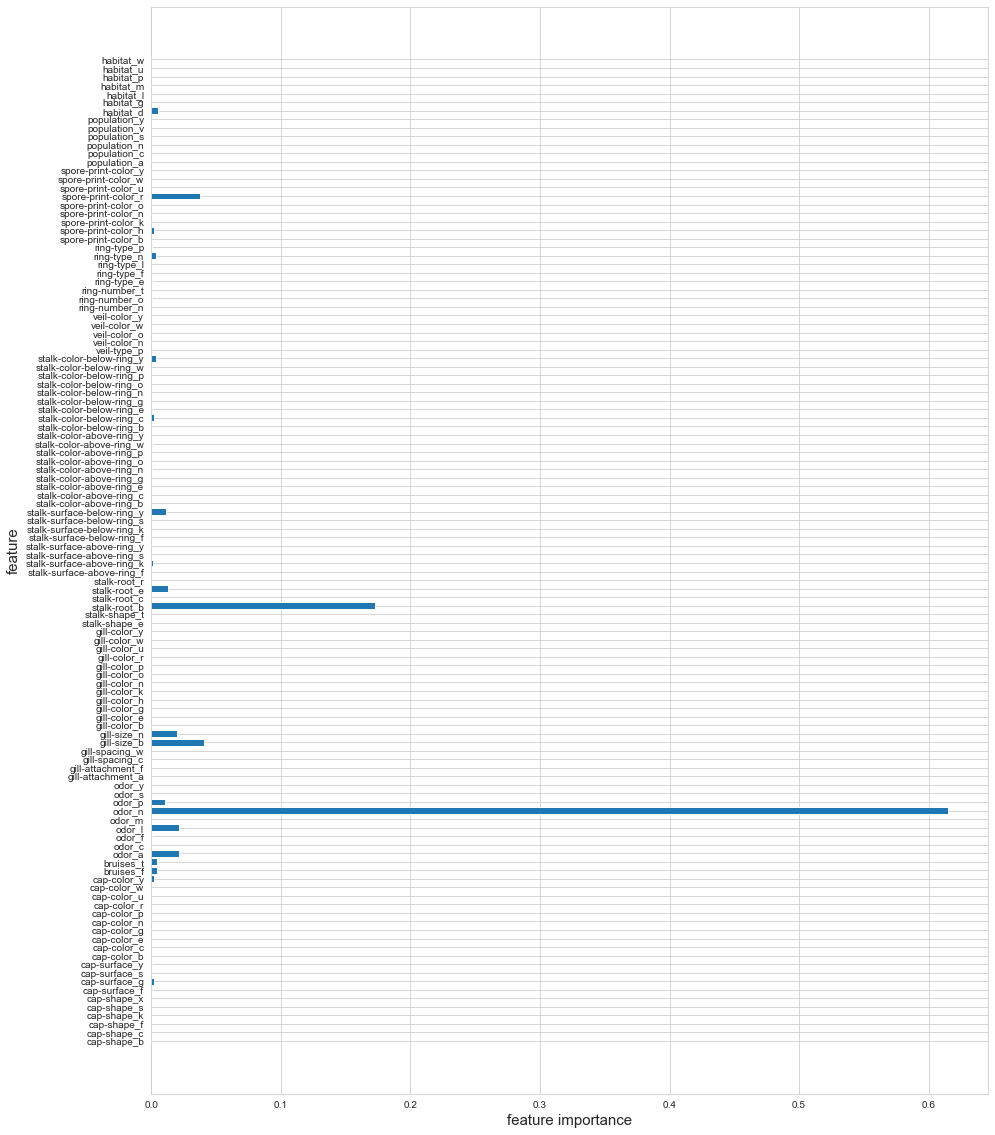

In [302]:
# 변수 중요도
gb_clf_2.fit(X_train, y_train)

feature_imp = gb_clf_2.feature_importances_

n_feature = X.shape[1]
idx = np.arange(n_feature)

plt.figure(figsize=(15,20))
plt.barh(idx, feature_imp, align='center')
plt.yticks(idx, X.columns)
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)
plt.show()

### AdaBoostClassifier

In [250]:
ada_clf_0 = AdaBoostClassifier(random_state=2021)

param_grid = [
    {'learning_rate':[0.1, 0.3, 0.5, 0.7, 1], 
    'n_estimators':[10, 50, 100, 200]}
]

result = GridSearchCV(ada_clf_0, param_grid = param_grid, scoring = 'f1', cv = 5)
result.fit(X, y)
result.best_params_

{'learning_rate': 0.3, 'n_estimators': 10}

In [262]:
ada_clf_2 =  AdaBoostClassifier(learning_rate=0.3, n_estimators=10, random_state = 2021)

cv = KFold(n_splits=5, shuffle=True, random_state=1)
cv_score = cross_val_score(ada_clf_2, X, y, cv=cv, scoring='f1')  
print('AdaBoostClassifier f1 score: ', np.round(cv_score.mean(),4), 
          '/each score of 5 fold: ', np.round(cv_score,4))

AdaBoostClassifier f1 score:  0.9746 /each score of 5 fold:  [0.969  0.9736 0.9705 0.9793 0.9807]


튜닝 결과, 5 fold cv의 mean f1 score는  0.9746이다.

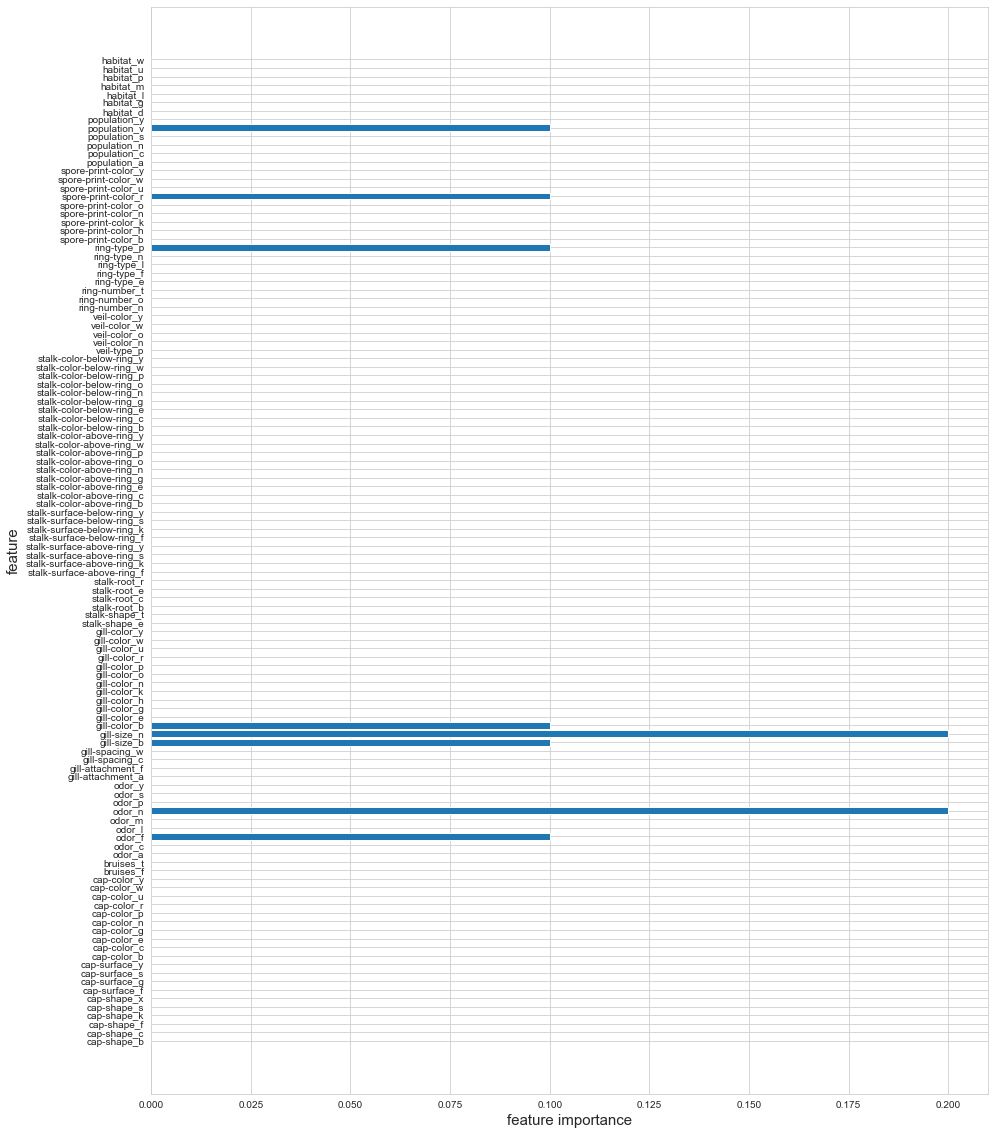

In [303]:
# 변수 중요도
ada_clf_2.fit(X_train, y_train)

feature_imp = ada_clf_2.feature_importances_

n_feature = X.shape[1]
idx = np.arange(n_feature)

plt.figure(figsize=(15,20))
plt.barh(idx, feature_imp, align='center')
plt.yticks(idx, X.columns)
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)
plt.show()

--------------------------------

모델의 5 fold cv mean f1 score를 비교해보면, 

- RandomForestClassifier: 0.9893
- ExtraTreesClassifier: 0.9685
- SVC: 1.0
- LogisticRegression: 0.9994
- GradientBoostingClassifier: 1.0
- AdaBoostClassifier: 0.9746

이들 중 f1 score이 높은 모델들만 선별하여 VotingClassifier를 통해 더 나은 모델을 만들어보기로 한다.

### Voting

In [304]:
voting_clf_hard = VotingClassifier(
 estimators=[('SVC', svm_clf_2), ('log', log_clf_2), ('gb', gb_clf_2)],
 voting='hard')

cv = KFold(n_splits=5, shuffle=True, random_state=1)
cv_score = cross_val_score(voting_clf_hard, X, y, cv=cv, scoring='f1')

print('VotingClassifier f1 score: ', np.round(cv_score.mean(),4), 
          '/each score of 5 fold: ', np.round(cv_score,4))

VotingClassifier f1 score:  1.0 /each score of 5 fold:  [1. 1. 1. 1. 1.]


In [305]:
voting_clf_soft = VotingClassifier(
 estimators=[('SVC', svm_clf_2), ('log', log_clf_2), ('gb', gb_clf_2)],
 voting='soft')

cv = KFold(n_splits=5, shuffle=True, random_state=1)
cv_score = cross_val_score(voting_clf_soft, X, y, cv=cv, scoring='f1')

print('VotingClassifier f1 score: ', np.round(cv_score.mean(),4), 
          '/each score of 5 fold: ', np.round(cv_score,4))

VotingClassifier f1 score:  1.0 /each score of 5 fold:  [1. 1. 1. 1. 1.]


SVC, LogisticRegression, GradientBoostingClassifier 세 모델을 soft/hard voting으로 앙상블한 결과, 모두 f1_score가 1이 나왔다. 단독 모델을 사용하는 것보다 세 모델을 앙상블하면 과적합 방지의 효과를 볼 수 있다. 따라서, 이미 세 단독 모델들의 f1 score가 1이지만 soft voting classifier도 같은 수치라면 후자가 일반화를 하기에는 더 좋은 모델이 될 수 있다.

## 결론

위에서는 hard voting과 soft voting의 성능이 1로 동일하게 나왔지만, 일반적으로 hard voting보다 soft voting이 성능이 좋다. 따라서 최종 모델은 SVC, LogisticRegression, GradientBoostingClassifier 세 모델을 soft voting으로 앙상블한 voting_clf_soft로 선택한다

< 앙상블에 사용한 개별 모델 > 

svm_clf_2 =  SVC(C=1, degree = 3, gamma = 'scale', 
                 kernel='linear', probability=True, random_state = 2021)

log_clf_2 =  LogisticRegression(C=1, penalty = 'l1', solver = 'liblinear', random_state = 2021)

gb_clf_2 =  GradientBoostingClassifier(learning_rate=0.2, max_depth = 5,
                                       max_leaf_nodes=9, min_samples_split=3,
                                       n_estimators=100, random_state = 2021)

< 최종 모델 > 

voting_clf_soft = VotingClassifier(
 estimators=[('SVC', svm_clf_2), ('log', log_clf_2), ('gb', gb_clf_2)],
 voting='soft')

In [307]:
voting_clf_soft.fit(X_train, y_train)
y_pred_train = voting_clf_soft.predict(X_train)
y_pred_test = voting_clf_soft.predict(X_test)

print('<Train set>')
print('confusion_matrix: ')
print(confusion_matrix(y_train, y_pred_train))
print('f1_score: ', f1_score(y_train, y_pred_train))
print('recall_score: ', recall_score(y_train, y_pred_train))
print('precision_score: ', precision_score(y_train, y_pred_train))

print('-----------------------')

print('<Test set>')
print('confusion_matrix: ')
print(confusion_matrix(y_test, y_pred_test))
print('f1_score: ', f1_score(y_test, y_pred_test))
print('recall_score: ', recall_score(y_test, y_pred_test))
print('precision_score: ', precision_score(y_test, y_pred_test))

<Train set>
confusion_matrix: 
[[3372    0]
 [   0 3127]]
f1_score:  1.0
recall_score:  1.0
precision_score:  1.0
-----------------------
<Test set>
confusion_matrix: 
[[836   0]
 [  0 789]]
f1_score:  1.0
recall_score:  1.0
precision_score:  1.0


test set에 대한 f1_score, recall_score, precision_score이 모두 1이며, 위 모델이 target이었던 class(edible/poisonous)를 완벽히 분류해내었다고 볼 수 있다.